# Day 8 Exercise

### Creating your own recommender engine pool and generating recommendations from a seed track

*A. Individual*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. Groupwork: For your sprint project*

4. Obtain a tracks dataset that is relevant to the client you are targeting. 
   For example:
   
    - A client artist's full discography (hint: use sp.playlist_tracks(ALBUM_ID) for every album of the artist)
    
    - Tracks from a popular playlist in spotify that your client artist appears in
    
    - Discographies of prospect artists to collaborate with 
    
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   
*C. Groupwork: For your sprint project*

7. Explore different seed tracks configurations:
    - A single track
    - A *representative track* made by aggregating the audio features and genre probabilities of all tracks in a chosen album/genre
    - A *hypothetical track* with specified desired audio feature values
    
8. For each choice of seed track in, generate using the recommender engine pool you made in (A). As a user, would you listen to the recommended tracks?

9. In addition to (2), check if the top 10 tracks with the **worst** similarity measure (i.e. most dissimilar to the seed track) make sense. As a user, do you agree that these are the tracks to be first discarded from the recommendation pool?



In [96]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Read the training data

In [97]:
# genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap", "Folk", \
#               "Metal", "OPM", "Punk", "Wedding", "Workout", "Breakup"] # a total of 17 genres

genre_names = ['r&b','pop', 'rap']

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


r&b
pop
rap


In [98]:
len(genre_names)

3

In [99]:
tracks_df['genre'].value_counts()

pop    1651
rap    1318
rnb    1058
Name: genre, dtype: int64

In [100]:
#check shape
playlist_df.shape, tracks_df.shape

((252, 7), (4027, 22))

In [101]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [102]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [103]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(3463, 22)

In [104]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

3436

In [105]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(3436, 22)

<AxesSubplot:>

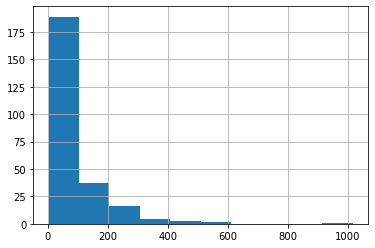

In [106]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

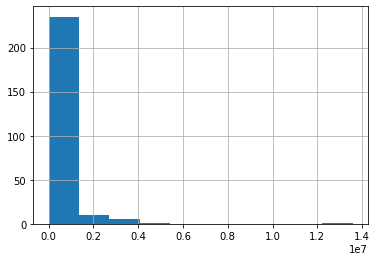

In [107]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [108]:
#tally of tracks
tracks_df['genre'].value_counts()
# tracks_df['genre'].value_counts(normalize=True)

pop    1647
rap    1295
rnb     494
Name: genre, dtype: int64

### 2. Refine the training data

In [109]:
playlist_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3343023,rnb
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2486483,rnb
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2070234,rnb
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,957270,rnb
4,37i9dQZF1DXbirtHQBuwCo,TrenChill K-R&B,70,spotify,Spotify,535401,rnb


In [110]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3343023,rnb
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2486483,rnb
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2070234,rnb
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,957270,rnb
4,37i9dQZF1DXbirtHQBuwCo,TrenChill K-R&B,70,spotify,Spotify,535401,rnb
0,37i9dQZF1DWTwnEm1IYyoj,Soft Pop Hits,232,spotify,Spotify,4735038,pop
1,37i9dQZF1DX50QitC6Oqtn,Love Pop,100,spotify,Spotify,3258215,pop
2,37i9dQZF1DXcZDD7cfEKhW,Pop Remix,50,spotify,Spotify,3214947,pop
3,37i9dQZF1DX6aTaZa0K6VA,Pop Up,80,spotify,Spotify,3008206,pop
4,37i9dQZF1DX9tPFwDMOaN1,K-Pop Daebak,50,spotify,Spotify,2780993,pop


In [111]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

pop    499
rnb    286
rap    238
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [112]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [113]:


tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    1023.000000
mean        0.651925
std         0.138702
min         0.000000
25%         0.568726
50%         0.670061
75%         0.745602
max         1.000000
Name: loudness, dtype: float64

In [114]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    1023.000000
mean        0.364987
std         0.182252
min         0.000000
25%         0.209020
50%         0.340805
75%         0.512163
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [115]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [116]:
tracks_df['genre'].value_counts()

pop    499
rnb    286
rap    238
Name: genre, dtype: int64

In [117]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
40,0JC3ynTNoZaWjZHXzeapYy,Into You (feat. Fabolous),0le01dl1WllSHhjEXRl4in,Tamia,0WdxQHUdLZBGbscwYV72zM,294093,2004,55,0.677,0.531,...,0.2190,0.00000,0.173,0.570,0.203167,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,4.901550,2
41,2RqZFOLOnzVmHUX7ZMcaES,Let It Go,1vfezMIyCr4XUdYRaKIKi3,Keyshia Cole,7mdy09EO4q6F9VWBtXDDjK,238333,2007-01-01,67,0.806,0.721,...,0.1970,0.00000,0.209,0.781,0.228107,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.972217,2
42,1zpu1PZ8ecmcX525Z3X8cl,Yo (Excuse Me Miss),7bXgB6jMjp9ATFy66eO08Z,Chris Brown,2gRm1k9fVkhTfZDHvBI2sR,229040,2005-11-29,0,0.605,0.633,...,0.1190,0.00000,0.225,0.592,0.178350,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.817333,2
43,4iuNZTcvT9diFySSzVsnVS,When I See U,7xAcVHPiirnUqfdqo0USb1,Fantasia,42DybH3gl3WcfXAQySOEiX,217346,2006-12-09,68,0.569,0.596,...,0.4570,0.00009,0.205,0.757,0.216273,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.622433,2
44,3LmvfNUQtglbTrydsdIqFU,We Belong Together,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,43iBTEWECK7hSnE0p6GgNo,201400,2005-01-01,68,0.837,0.462,...,0.0339,0.00000,0.090,0.762,0.518755,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.356667,2


In [118]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'rnb', 0: 'pop', 1: 'rap'}

### PCA

In [119]:
# from sklearn.decomposition import PCA

In [120]:
# pca = PCA(n_components=0.90)

In [121]:
# X = tracks_df[feature_cols]
# y = tracks_df['genre_id']

# X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)

In [122]:
# pca.fit(X_train)

# #Transform the train and test dataset
# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)

In [123]:
# print("X_train_pca:{}".format(X_train_pca.shape))
# print("X_test_pca:{}".format(X_test_pca.shape))

In [124]:
# component_label = ["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6"]

# #Put it in a dataframe
# X_train_pca_df = pd.DataFrame(X_train_pca, columns=component_label, index=X_train.index)

# #View the DataFrame
# X_train_pca_df.head(3)

In [125]:
# print("Explained Variance Ratio per PC: %s" % pca.explained_variance_ratio_)
# print("Explained Variance Ratio Total: %.2f" % pca.explained_variance_ratio_.sum())

## 4. Train a KNN model

In [126]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model

### kNN


Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(818, 9)
Shape of y_Train:(818,)
Shape of X_Test:(205, 9)
Shape of y_Test:(205,)
Finding best k...


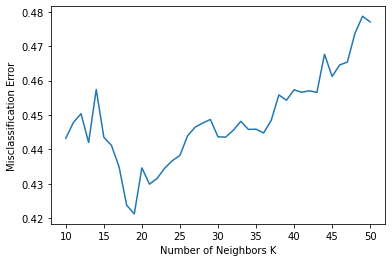

The optimal number of neighbors is 19 with score 57%


In [467]:
#Select audio features to use for the model
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']

feature_cols = ['danceability','energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
results_optimal_k = []

# kfolds= [4,5,8,10]
kfolds= [10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(10,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=d, scoring='f1_macro')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X_train, Y_train)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [128]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[19]

### SVM

<AxesSubplot:>

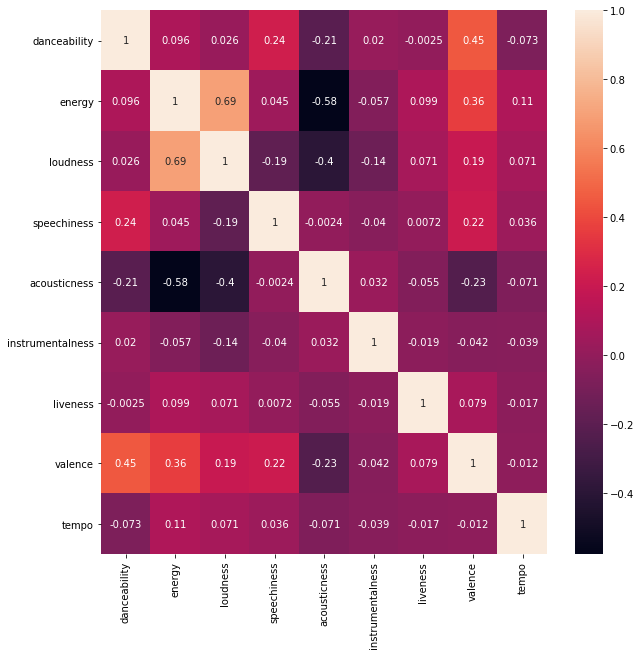

In [129]:
plt.figure(figsize=(10,10))
sns.heatmap( tracks_df[feature_cols].corr(), annot=True)

In [130]:
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']

In [131]:
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

In [132]:
param_grid = {'degree': np.arange(2,6)
                 }

In [133]:
svm_model = SVC(kernel='poly')

In [134]:
grid_search_no_pipeline = GridSearchCV(svm_model, param_grid=param_grid, cv=10)

In [135]:
grid_search_no_pipeline.fit(X,y)

GridSearchCV(cv=10, estimator=SVC(kernel='poly'),
             param_grid={'degree': array([2, 3, 4, 5])})

In [136]:
print("Best estimator:")
print(grid_search_no_pipeline.best_estimator_)

Best estimator:
SVC(kernel='poly')


In [137]:
print("Best parameters:")
print(grid_search_no_pipeline.best_params_)

Best parameters:
{'degree': 3}


In [138]:
best_score = grid_search_no_pipeline.best_score_

print("Best score: %.2f" % (best_score * 100))

Best score: 65.10


In [139]:
# #Select audio features to use for the model
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']

# # create feature matrix (X)
# X = tracks_df[feature_cols]
# y = tracks_df['genre_id']

# # creating training set, test set and checking shapes 
# # X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
# # print("Shape of X_Train:"+str(X_train.shape))
# # print("Shape of y_Train:"+str(Y_train.shape))
# # print("Shape of X_Test:"+str(X_test.shape))
# # print("Shape of y_Test:"+str(Y_test.shape))
    
# #train model
# cv_scores = []
# svm_model1 = SVC(kernel='poly', degree=3) # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
# scores = cross_val_score(svm_model1, X, y, cv=10, scoring='accuracy')
# scores.mean()

### RandomForest

In [140]:
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']

In [141]:
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

In [142]:
tracks_df.shape

(1023, 24)

In [143]:
param_grid = {'min_samples_split':[2,5,10],
                    'min_samples_leaf':[2,5, 10]}

In [144]:
clf = RandomForestClassifier(max_features='sqrt', criterion='gini')

In [145]:
grid_search_no_pipeline = GridSearchCV(clf, param_grid=param_grid, cv=5)

In [146]:
grid_search_no_pipeline.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features='sqrt'),
             param_grid={'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [147]:
print("Best estimator:")
print(grid_search_no_pipeline.best_estimator_)

Best estimator:
RandomForestClassifier(max_features='sqrt', min_samples_leaf=2)


In [148]:
print("Best parameters:")
print(grid_search_no_pipeline.best_params_)

Best parameters:
{'min_samples_leaf': 2, 'min_samples_split': 2}


In [149]:
best_score = grid_search_no_pipeline.best_score_

print("Best score: %.2f" % (best_score * 100))

Best score: 65.79


In [150]:
# #Select audio features to use for the model
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']

# # create feature matrix (X)
# X = tracks_df[feature_cols]
# y = tracks_df['genre_id']

# # creating training set, test set and checking shapes 
# # X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
# # print("Shape of X_Train:"+str(X_train.shape))
# # print("Shape of y_Train:"+str(Y_train.shape))
# # print("Shape of X_Test:"+str(X_test.shape))
# # print("Shape of y_Test:"+str(Y_test.shape))
    
# #train model
# cv_scores = []
# clf = RandomForestClassifier(max_features='sqrt')
# scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
# scores.mean()

### AdaBoost

In [151]:
# #Select audio features to use for the model
# # feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
# #                 'liveness', 'valence', 'tempo']

# # create feature matrix (X)
# X = tracks_df[feature_cols]
# y = tracks_df['genre_id']
    
# #train model
# cv_scores = []
# clf = AdaBoostClassifier(n_estimators=100)
# scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
# scores.mean()

In [152]:
while

SyntaxError: invalid syntax (<ipython-input-152-ae84bbebe3ce>, line 1)

### 5. Model Prediction

In [153]:
tracks_df.shape

(1023, 24)

In [154]:
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
40,0JC3ynTNoZaWjZHXzeapYy,Into You (feat. Fabolous),0le01dl1WllSHhjEXRl4in,Tamia,0WdxQHUdLZBGbscwYV72zM,294093,2004,55,0.677,0.531,...,0.2190,0.00000,0.173,0.570,0.203167,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,4.901550,2
41,2RqZFOLOnzVmHUX7ZMcaES,Let It Go,1vfezMIyCr4XUdYRaKIKi3,Keyshia Cole,7mdy09EO4q6F9VWBtXDDjK,238333,2007-01-01,67,0.806,0.721,...,0.1970,0.00000,0.209,0.781,0.228107,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.972217,2
42,1zpu1PZ8ecmcX525Z3X8cl,Yo (Excuse Me Miss),7bXgB6jMjp9ATFy66eO08Z,Chris Brown,2gRm1k9fVkhTfZDHvBI2sR,229040,2005-11-29,0,0.605,0.633,...,0.1190,0.00000,0.225,0.592,0.178350,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.817333,2
43,4iuNZTcvT9diFySSzVsnVS,When I See U,7xAcVHPiirnUqfdqo0USb1,Fantasia,42DybH3gl3WcfXAQySOEiX,217346,2006-12-09,68,0.569,0.596,...,0.4570,0.00009,0.205,0.757,0.216273,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.622433,2
44,3LmvfNUQtglbTrydsdIqFU,We Belong Together,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,43iBTEWECK7hSnE0p6GgNo,201400,2005-01-01,68,0.837,0.462,...,0.0339,0.00000,0.090,0.762,0.518755,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.356667,2


In [167]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2,-6.209,1,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,88,0.358,0.557,10,-7.398,1,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,87,0.748,0.524,8,-5.599,1,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,0,-8.821,1,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,1,0.783,0.623,7,-6.126,1,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [156]:
chart_tracks_df.shape

(3284, 19)

In [168]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [158]:
len( list(genre_lookup.values()) )

3

In [159]:
list(genre_lookup.values())

['rnb', 'pop', 'rap']

In [169]:
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
# feature_cols = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness']
genre_names = list(genre_lookup.values())
genres = [genre_lookup[i] for i in np.arange( len( list(genre_lookup.values()) ) )]

n=0 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 19


In [170]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3141,1NUw61RX4Wtmxw7CLiP4kP,Paubaya,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0jIt32srcZv1X5ToMG3f8E,282490,2020-10-31,67,0.373,0.245,...,0.000365,0.0768,0.174,0.458380,0,pop,1.0,1.0,0.0,0.0
1596,1yjY7rpaAQvKwpdUliHx0d,Still into You,74XFHRwlV6OrjEM0A2NCMF,Paramore,4sgYpkIASM1jVlNC8Wp9oF,216013,2013-04-05,79,0.602,0.923,...,0.000000,0.0561,0.765,0.513408,0,pop,1.0,1.0,0.0,0.0
2806,0sNZsYY8LSCCM4tC2y0zR1,Binhi,7uDdl5V5AETSFY7K3muu22,Arthur Nery,3H8htbv4nP3HIjpOCbxm67,216774,2019-10-25,63,0.545,0.309,...,0.000733,0.1890,0.232,0.438075,0,pop,1.0,1.0,0.0,0.0
947,5SXEEYJxc5OPoOn5H9SHvX,Crystal Snow,3Nrfpe0tUJi4K4DXYWgMUX,BTS,04hXnHSqRyuodKyXnz3vHW,322333,2017-12-06,0,0.618,0.768,...,0.000000,0.1200,0.483,0.377681,0,pop,1.0,1.0,0.0,0.0
1161,0ztDBQdQmdVZvorSmIjMih,Tagpuan,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,05rQadwAVYTpNNnBoeTuj0,260240,2018-02-19,66,0.566,0.121,...,0.000000,0.0788,0.293,0.508842,0,pop,1.0,1.0,0.0,0.0


In [171]:
chart_tracks_df.head().describe()

,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.0,5.0
mean,259570.000000,55.000000,0.540800,0.473200,5.200000,0.672459,1.0,0.035500,0.544960,0.000220,0.104140,0.389400,0.459277,0.0,1.0,1.0,0.0,0.0
std,45259.472307,31.344856,0.098126,0.350824,1.788854,0.151935,0.0,0.005028,0.442828,0.000328,0.052797,0.239949,0.055891,0.0,0.0,0.0,0.0,0.0
min,216013.000000,0.000000,0.373000,0.121000,3.000000,0.483112,1.0,0.031300,0.009800,0.000000,0.056100,0.174000,0.377681,0.0,1.0,1.0,0.0,0.0
25%,216774.000000,63.000000,0.545000,0.245000,5.000000,0.573797,1.0,0.032300,0.126000,0.000000,0.076800,0.232000,0.438075,0.0,1.0,1.0,0.0,0.0
50%,260240.000000,66.000000,0.566000,0.309000,5.000000,0.656868,1.0,0.034500,0.766000,0.000000,0.078800,0.293000,0.458380,0.0,1.0,1.0,0.0,0.0
75%,282490.000000,67.000000,0.602000,0.768000,5.000000,0.809744,1.0,0.035400,0.862000,0.000365,0.120000,0.483000,0.508842,0.0,1.0,1.0,0.0,0.0
max,322333.000000,79.000000,0.618000,0.923000,8.000000,0.838772,1.0,0.044000,0.961000,0.000733,0.189000,0.765000,0.513408,0.0,1.0,1.0,0.0,0.0


In [172]:
knn_optimal.predict_proba( chart_tracks_df.iloc[1][feature_cols].values.reshape(1,-1) )

array([[1., 0., 0.]])

Check out tracks with highest assigned probability

In [173]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
3141,Moira Dela Torre,Paubaya,pop,1.000000
1596,Paramore,Still into You,pop,1.000000
2806,Arthur Nery,Binhi,pop,1.000000
947,BTS,Crystal Snow,pop,1.000000
1161,Moira Dela Torre,Tagpuan,pop,1.000000
220,Aminé,Caroline,rap,0.947368
214,Aminé,Caroline,rap,0.947368
1789,Lavaado,Switch It Up,rap,0.947368
2101,Logic,Homicide (feat. Eminem),rap,0.894737
2093,Logic,Homicide,rap,0.894737


View histogram of predicted genre probabilities

<AxesSubplot:>

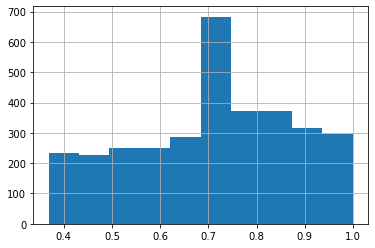

In [174]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [175]:
chart_tracks_df['predicted_genre'].value_counts()

pop    2841
rnb     258
rap     185
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [176]:
this_song = 'SONG NAME HERE'
chart_tracks_df[chart_tracks_df['track_name']=='Not Shy'][['predicted_genre','predicted_genre_prob']]

,predicted_genre,predicted_genre_prob
2953,pop,0.789474
2951,pop,0.789474


In [177]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [178]:
#read data
chart_tracks_df=pd.read_csv("data/spotify_daily_charts_tracks_predicted_genres.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
0,1NUw61RX4Wtmxw7CLiP4kP,Paubaya,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0jIt32srcZv1X5ToMG3f8E,282490,2020-10-31,67,0.373,0.245,...,0.000365,0.0768,0.174,0.458380,0,pop,1.0,1.0,0.0,0.0
1,1yjY7rpaAQvKwpdUliHx0d,Still into You,74XFHRwlV6OrjEM0A2NCMF,Paramore,4sgYpkIASM1jVlNC8Wp9oF,216013,2013-04-05,79,0.602,0.923,...,0.000000,0.0561,0.765,0.513408,0,pop,1.0,1.0,0.0,0.0
2,0sNZsYY8LSCCM4tC2y0zR1,Binhi,7uDdl5V5AETSFY7K3muu22,Arthur Nery,3H8htbv4nP3HIjpOCbxm67,216774,2019-10-25,63,0.545,0.309,...,0.000733,0.1890,0.232,0.438075,0,pop,1.0,1.0,0.0,0.0
3,5SXEEYJxc5OPoOn5H9SHvX,Crystal Snow,3Nrfpe0tUJi4K4DXYWgMUX,BTS,04hXnHSqRyuodKyXnz3vHW,322333,2017-12-06,0,0.618,0.768,...,0.000000,0.1200,0.483,0.377681,0,pop,1.0,1.0,0.0,0.0
4,0ztDBQdQmdVZvorSmIjMih,Tagpuan,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,05rQadwAVYTpNNnBoeTuj0,260240,2018-02-19,66,0.566,0.121,...,0.000000,0.0788,0.293,0.508842,0,pop,1.0,1.0,0.0,0.0


In [233]:
repr_feats_df = pd.DataFrame(np.array( chart_tracks_df[ chart_tracks_df['artist_name']=='ITZY' ][feature_cols].mean() ).reshape(1,-1), \
                         index = ['scores'], columns = feature_cols)
repr_feats_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
scores,0.78575,0.900375,0.840056,0.091225,0.059077,0.00006,0.285375,0.677375,0.403434


In [234]:
repr_feats_df['predicted_genre_id'] = repr_feats_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
repr_feats_df['predicted_genre'] = repr_feats_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
repr_feats_df['predicted_genre_prob'] = repr_feats_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
repr_feats_df['all_genre_prob'] = repr_feats_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)

In [235]:
repr_feats_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,all_genre_prob
scores,0.78575,0.900375,0.840056,0.091225,0.059077,0.00006,0.285375,0.677375,0.403434,0,pop,0.947368,"[0.9473684210526315, 0.05263157894736842, 0.0]"


In [236]:
#explode genre probabilities into separate columns
repr_predicted_genre_prob = pd.DataFrame(repr_feats_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres], index=['scores'])

repr_predicted_genre_prob

,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
scores,0.947368,0.052632,0.0


In [237]:
repr_feats_df = pd.concat( [repr_feats_df.drop('all_genre_prob', axis=1), repr_predicted_genre_prob], axis=1 )

repr_feats_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
scores,0.78575,0.900375,0.840056,0.091225,0.059077,0.00006,0.285375,0.677375,0.403434,0,pop,0.947368,0.947368,0.052632,0.0


In [ ]:
# Input seed track here
# seed_track_name = "Not Shy"

In [ ]:
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']

In [ ]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[ feature_cols + ['track_id'] ]

In [240]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  repr_feats_df[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
chart_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,liveness,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,cosine_dist
0,1NUw61RX4Wtmxw7CLiP4kP,Paubaya,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0jIt32srcZv1X5ToMG3f8E,282490,2020-10-31,67,0.373,0.245,...,0.0768,0.174,0.458380,0,pop,1.000000,1.000000,0.000000,0.000000,0.319512
1,1yjY7rpaAQvKwpdUliHx0d,Still into You,74XFHRwlV6OrjEM0A2NCMF,Paramore,4sgYpkIASM1jVlNC8Wp9oF,216013,2013-04-05,79,0.602,0.923,...,0.0561,0.765,0.513408,0,pop,1.000000,1.000000,0.000000,0.000000,0.019707
2,0sNZsYY8LSCCM4tC2y0zR1,Binhi,7uDdl5V5AETSFY7K3muu22,Arthur Nery,3H8htbv4nP3HIjpOCbxm67,216774,2019-10-25,63,0.545,0.309,...,0.1890,0.232,0.438075,0,pop,1.000000,1.000000,0.000000,0.000000,0.301888
3,5SXEEYJxc5OPoOn5H9SHvX,Crystal Snow,3Nrfpe0tUJi4K4DXYWgMUX,BTS,04hXnHSqRyuodKyXnz3vHW,322333,2017-12-06,0,0.618,0.768,...,0.1200,0.483,0.377681,0,pop,1.000000,1.000000,0.000000,0.000000,0.010803
4,0ztDBQdQmdVZvorSmIjMih,Tagpuan,0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,05rQadwAVYTpNNnBoeTuj0,260240,2018-02-19,66,0.566,0.121,...,0.0788,0.293,0.508842,0,pop,1.000000,1.000000,0.000000,0.000000,0.311382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279,2Eeur20xVqfUoM3Q7EFPFt,the last great american dynasty,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2fenSS68JI1h4Fo296JfGr,230999,2020-07-24,78,0.686,0.662,...,0.1090,0.706,0.586704,0,pop,0.368421,0.368421,0.263158,0.368421,0.061220
3280,0PgYPBGqF6Wm5KFHQ81nq5,comethru (with Bea Miller),3gIRvgZssIb9aiirIg0nI3,Jeremy Zucker,10Dr3GO6OzrOwJwoY11IoH,181626,2019-03-15,72,0.757,0.192,...,0.6060,0.595,0.255061,2,rnb,0.368421,0.315789,0.315789,0.368421,0.195844
3281,0sdbFOyfgAhAhWq8DpzkaW,the light is coming (feat. Nicki Minaj),66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,3tx8gQqWbGwqIGZHqDNrGe,228373,2018-08-17,68,0.877,0.547,...,0.0280,0.687,0.285888,2,rnb,0.368421,0.315789,0.315789,0.368421,0.038149
3282,7m9OqQk4RVRkw9JJdeAw96,Jocelyn Flores,15UsOTVnJzReFVN1VCnxy4,XXXTENTACION,5VdyJkLe3yvOs0l4xXbWp0,119133,2017-08-25,90,0.872,0.391,...,0.2970,0.437,0.501169,0,pop,0.368421,0.368421,0.263158,0.368421,0.105788


In [ ]:
#get top 10 with lowest cosine distance to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

In [ ]:
#get top 10 with lowest cosine distance to seed_track_data AND same 'predicted_genre'
recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
                                    [chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                    .sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

In [241]:
genre_cols = [col for col in chart_tracks_df.columns if ('predicted_' in col)&('genre' not in col)]
cols = feature_cols + genre_cols

In [242]:
cols

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'predicted_pop_prob',
 'predicted_rap_prob',
 'predicted_rnb_prob']

In [247]:
#Audio features + predicted genre probabilities
genre_cols = [col for col in chart_tracks_df.columns if ('predicted_' in col)&('genre' not in col)]
cols = feature_cols + genre_cols
chart_tracks_df['cosine_dist_mod'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[cols].values.reshape(1, -1),\
                                                                  repr_feats_df[cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
recommendation_df = chart_tracks_df[ (chart_tracks_df['artist_name'] != 'ITZY') ]\
                                   .sort_values('cosine_dist_mod').drop_duplicates('track_name')
recommendation_df[['track_name','artist_name','cosine_dist_mod','predicted_genre']+cols]

,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
304,Peek-A-Boo,Red Velvet,0.001654,pop,0.839,0.9020,0.844954,0.0536,0.0868,0.002570,0.2720,0.6390,0.383841,0.894737,0.052632,0.052632
132,Dynamite - Tropical Remix,BTS,0.002000,pop,0.729,0.8960,0.857400,0.0667,0.0295,0.000002,0.2340,0.6200,0.378192,0.947368,0.000000,0.052632
257,Anywhere,Sigma,0.003201,pop,0.717,0.8720,0.858588,0.0357,0.0162,0.000002,0.2050,0.6100,0.415056,0.947368,0.000000,0.052632
129,Rain On Me (with Ariana Grande),Lady Gaga,0.003261,pop,0.672,0.8550,0.838731,0.0397,0.0210,0.000000,0.3230,0.6460,0.433700,0.947368,0.000000,0.052632
196,HEY BUDDY,SEVENTEEN,0.003407,pop,0.768,0.8870,0.835496,0.1100,0.0284,0.000000,0.2300,0.5400,0.389975,0.947368,0.000000,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,Skit,BTS,0.412331,rap,0.703,0.3210,0.455067,0.8840,0.8640,0.000000,0.9080,0.5440,0.383034,0.157895,0.736842,0.105263
1477,Sunset Lover,Petit Biscuit,0.431236,rnb,0.783,0.4670,0.604954,0.0503,0.7290,0.809000,0.1090,0.2360,0.235457,0.052632,0.210526,0.736842
2224,Pasko Na Sinta Ko,Gary Valenciano,0.443059,pop,0.279,0.0824,0.116315,0.0338,0.7350,0.000227,0.0685,0.0942,0.176485,0.631579,0.000000,0.368421
2421,Chromatica II,Lady Gaga,0.539544,rnb,0.184,0.2970,0.397789,0.0359,0.4730,0.893000,0.5270,0.1130,0.143073,0.210526,0.210526,0.578947


In [245]:
recommendation_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_pop_prob', 'predicted_rap_prob', 'predicted_rnb_prob',
       'cosine_dist', 'cosine_dist_mod'],
      dtype='object')

In [248]:
recommendation_df['predicted_genre'].unique()

array(['pop', 'rap', 'rnb'], dtype=object)

In [444]:
top_recomms_df = recommendation_df.groupby('predicted_genre').head(10000)[['track_id','track_name','artist_name','cosine_dist_mod','predicted_genre']+cols]\
.sort_values(['predicted_genre', 'cosine_dist_mod'])

top_recomms_df

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
304,42tFTth2jcF7iSo0RBjfJF,Peek-A-Boo,Red Velvet,0.001654,pop,0.839,0.902,0.844954,0.0536,0.0868,0.002570,0.2720,0.6390,0.383841,0.894737,0.052632,0.052632
132,7r6bu5Xd0q2TK1QQMduxb8,Dynamite - Tropical Remix,BTS,0.002000,pop,0.729,0.896,0.857400,0.0667,0.0295,0.000002,0.2340,0.6200,0.378192,0.947368,0.000000,0.052632
257,6lD9nDl7jBUSIPDMAMZjuD,Anywhere,Sigma,0.003201,pop,0.717,0.872,0.858588,0.0357,0.0162,0.000002,0.2050,0.6100,0.415056,0.947368,0.000000,0.052632
129,7ju97lgwC2rKQ6wwsf9no9,Rain On Me (with Ariana Grande),Lady Gaga,0.003261,pop,0.672,0.855,0.838731,0.0397,0.0210,0.000000,0.3230,0.6460,0.433700,0.947368,0.000000,0.052632
196,1hd8IgMElWy3OqcFVjZMUx,HEY BUDDY,SEVENTEEN,0.003407,pop,0.768,0.887,0.835496,0.1100,0.0284,0.000000,0.2300,0.5400,0.389975,0.947368,0.000000,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,3CGZ7wfk4skmuyQgua1C1K,Chromatica I,Lady Gaga,0.391249,rnb,0.231,0.457,0.551771,0.0318,0.0126,0.875000,0.3270,0.0588,0.081560,0.421053,0.052632,0.526316
2470,4GKk1uNzpxIptBuaY97Dkj,Midnight,Coldplay,0.405863,rnb,0.548,0.475,0.484340,0.0355,0.6150,0.808000,0.0944,0.0349,0.457808,0.263158,0.157895,0.578947
1477,0hNduWmlWmEmuwEFcYvRu1,Sunset Lover,Petit Biscuit,0.431236,rnb,0.783,0.467,0.604954,0.0503,0.7290,0.809000,0.1090,0.2360,0.235457,0.052632,0.210526,0.736842
2421,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,Lady Gaga,0.539544,rnb,0.184,0.297,0.397789,0.0359,0.4730,0.893000,0.5270,0.1130,0.143073,0.210526,0.210526,0.578947


In [445]:
kpop_artists = ['Red Velvet', 'TWICE', 'BTS', 'SB19', 'SEVENTEEN', 'BLACKPINK', 'X1', 'TOMORROW X TOGETHER', 'EXO', 'EXO-SC'\
               ,'WINNER', 'j-hope']

In [446]:
pop_recomms = top_recomms_df[ (top_recomms_df['predicted_genre']=='pop') & ~(top_recomms_df.artist_name.isin(kpop_artists)) ]
pop_recomms

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
257,6lD9nDl7jBUSIPDMAMZjuD,Anywhere,Sigma,0.003201,pop,0.717,0.8720,0.858588,0.0357,0.0162,0.000002,0.2050,0.6100,0.415056,0.947368,0.0,0.052632
129,7ju97lgwC2rKQ6wwsf9no9,Rain On Me (with Ariana Grande),Lady Gaga,0.003261,pop,0.672,0.8550,0.838731,0.0397,0.0210,0.000000,0.3230,0.6460,0.433700,0.947368,0.0,0.052632
537,6t2ubAB4iSYOuIpRAOGd4t,Cake - Challenge Version,Flo Rida,0.004508,pop,0.786,0.8540,0.818956,0.0523,0.0729,0.000002,0.1790,0.6870,0.323078,0.894737,0.0,0.105263
572,7aV2mflaASUmGhCErm7kBO,The Mack,Nevada,0.004604,pop,0.707,0.8830,0.817564,0.0602,0.0707,0.000000,0.2300,0.5410,0.328942,0.894737,0.0,0.105263
321,40nPimvmG05WYS7983bawZ,Cry for Me,Camila Cabello,0.004676,pop,0.721,0.8050,0.823582,0.0927,0.0500,0.000000,0.1530,0.6530,0.402946,0.894737,0.0,0.105263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,4eqne0oIdt9GW2ubiliny0,"Have Yourself A Merry Little Christmas - ""Meet...",Judy Garland,0.395985,pop,0.273,0.1610,0.334043,0.0357,0.9610,0.000905,0.1120,0.1110,0.071303,0.789474,0.0,0.210526
362,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,Kina Grannis,0.397282,pop,0.266,0.0596,0.234800,0.0363,0.9050,0.000071,0.1320,0.1430,0.794792,0.894737,0.0,0.105263
507,7uuEfUMuPeQ7RlSWa0cES2,Can’t Help Falling in Love,Kina Grannis,0.397282,pop,0.266,0.0596,0.234800,0.0363,0.9050,0.000071,0.1320,0.1430,0.794792,0.894737,0.0,0.105263
1334,6f8b6mxNNDJdE5tC4MCTxt,Never Enough (Reprise),Loren Allred,0.403792,pop,0.382,0.0541,0.199550,0.0300,0.8890,0.000003,0.0832,0.1330,0.184066,0.789474,0.0,0.210526


In [447]:
rnb_recomms = top_recomms_df[ (top_recomms_df['predicted_genre']=='rnb') & ~(top_recomms_df.artist_name.isin(kpop_artists)) ]
rnb_recomms

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3017,7txPE73wHbuXYkM1h8zNrG,Mob Ties,Drake,0.086388,rnb,0.755,0.575,0.649253,0.0673,0.0443,0.001270,0.2760,0.4930,0.205651,0.421053,0.105263,0.473684
2608,4iLqG9SeJSnt0cSPICSjxv,Attention,Charlie Puth,0.089567,rnb,0.774,0.626,0.811382,0.0432,0.0969,0.000031,0.0848,0.7770,0.292085,0.473684,0.000000,0.526316
2895,6Yx181fZzA0YE2EkUsYruq,Big Plans,Why Don't We,0.091109,rnb,0.693,0.604,0.776704,0.0427,0.0668,0.000000,0.1140,0.6510,0.138089,0.421053,0.105263,0.473684
2907,2Gl0FzuLxflY6nPifJp5Dr,First Time,Kygo,0.091667,rnb,0.633,0.592,0.696213,0.1120,0.1970,0.000000,0.0990,0.6790,0.230707,0.421053,0.105263,0.473684
2881,3A7qX2QjDlPnazUsRk5y0M,2U (feat. Justin Bieber),David Guetta,0.093016,rnb,0.548,0.650,0.754268,0.0591,0.2190,0.000000,0.2250,0.5570,0.568337,0.421053,0.105263,0.473684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,3CGZ7wfk4skmuyQgua1C1K,Chromatica I,Lady Gaga,0.391249,rnb,0.231,0.457,0.551771,0.0318,0.0126,0.875000,0.3270,0.0588,0.081560,0.421053,0.052632,0.526316
2470,4GKk1uNzpxIptBuaY97Dkj,Midnight,Coldplay,0.405863,rnb,0.548,0.475,0.484340,0.0355,0.6150,0.808000,0.0944,0.0349,0.457808,0.263158,0.157895,0.578947
1477,0hNduWmlWmEmuwEFcYvRu1,Sunset Lover,Petit Biscuit,0.431236,rnb,0.783,0.467,0.604954,0.0503,0.7290,0.809000,0.1090,0.2360,0.235457,0.052632,0.210526,0.736842
2421,0oQc0F6KUE7QY7k5TU6bic,Chromatica II,Lady Gaga,0.539544,rnb,0.184,0.297,0.397789,0.0359,0.4730,0.893000,0.5270,0.1130,0.143073,0.210526,0.210526,0.578947


In [448]:
rap_recomms = top_recomms_df[ (top_recomms_df['predicted_genre']=='rap') & ~(top_recomms_df.artist_name.isin(kpop_artists)) ]
rap_recomms

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3001,01iyINEYgPQ7ThMZuHUsqS,First Love,Lost Kings,0.085184,rap,0.619,0.938,0.778096,0.350,0.0257,0.000014,0.1280,0.601,0.257252,0.421053,0.473684,0.105263
3158,6qNALlmZa1ESnCxJmXE1K9,The Way I Am,Charlie Puth,0.091890,rap,0.755,0.769,0.761187,0.186,0.3140,0.000002,0.0628,0.642,0.383921,0.368421,0.421053,0.210526
3049,6u7jPi22kF8CTQ3rb9DHE7,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,0.093538,rap,0.878,0.619,0.765200,0.102,0.0533,0.000000,0.1130,0.639,0.513598,0.368421,0.473684,0.157895
3024,2YpeDb67231RjR0MgVLzsG,Old Town Road - Remix,Lil Nas X,0.093538,rap,0.878,0.619,0.765200,0.102,0.0533,0.000000,0.1130,0.639,0.513598,0.368421,0.473684,0.157895
3204,6LcauUZjF1eXQrgqMUecHX,Ayy Macarena,Tyga,0.093649,rap,0.816,0.630,0.764872,0.226,0.1330,0.000000,0.0692,0.715,0.270253,0.368421,0.421053,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,3eze1OsZ1rqeXkKStNfTmi,Juke Jam (feat. Justin Bieber & Towkio),Chance the Rapper,0.321284,rap,0.505,0.397,0.610072,0.324,0.7160,0.000000,0.0853,0.558,0.261454,0.105263,0.631579,0.263158
1920,1iV24xOkfxyD2Jb0NCC1Fj,"Come with Me (feat. Bosx1ne, Flow-G, King Badg...",Ex Battalion,0.334015,rap,0.555,0.448,0.618915,0.363,0.5270,0.000036,0.0497,0.749,0.081129,0.000000,0.684211,0.315789
1166,43rA71bccXFGD4C8GOpIlN,I Forgot That You Existed,Taylor Swift,0.352651,rap,0.664,0.316,0.569294,0.519,0.2980,0.000002,0.0812,0.541,0.247991,0.000000,0.789474,0.210526
1736,3hB5DgAiMAQ4DzYbsMq1IT,Love Yourself,Justin Bieber,0.362147,rap,0.609,0.378,0.590461,0.438,0.8350,0.000000,0.2800,0.515,0.294404,0.052632,0.684211,0.263158


In [449]:
top_recomms_df_wokpop.artist_name.unique()

array(['Sigma', 'Lady Gaga', 'Flo Rida', 'Nevada', 'Camila Cabello',
       'Ariana Grande', 'Charli XCX', 'Axwell /\\ Ingrosso',
       'IV Of Spades', 'Calvin Harris', 'The Chainsmokers', 'Dua Lipa',
       'Mike Perry', 'Bazzi', 'LANY', 'Kris Kross Amsterdam', 'Drake',
       'Charlie Puth', "Why Don't We", 'Kygo', 'David Guetta',
       'Matt Terry', 'The Script', 'Marc E. Bassy', 'Justin Bieber',
       'Loote', 'Rita Ora', 'Curtis Waters', 'Timeflies', 'R. Kelly',
       'OneRepublic', 'Dawin', 'Twenty One Pilots', 'Wiz Khalifa',
       'blackbear', 'James Reid', 'Ben&Ben', 'Ex Battalion', 'FLETCHER',
       'SZA', 'Lost Kings', 'Lil Nas X', 'Tyga', 'Demi Lovato',
       'Jax Jones', 'Lil Uzi Vert', 'The Carters', 'Nick Jonas',
       'Shawn Mendes', 'Pop Smoke', 'Beyoncé', 'Karencitta',
       'Megan Thee Stallion', 'Ne-Yo', 'Nicki Minaj', 'Kendrick Lamar',
       'Chris Brown', 'Ray J', 'Selena Gomez', 'Migos'], dtype=object)

In [450]:
top_recomms_df_wokpop = pd.concat( [pop_recomms, rnb_recomms, rap_recomms] )
top_recomms_df_wokpop.groupby('predicted_genre').size()

predicted_genre
pop    2024
rap     138
rnb     186
dtype: int64

In [451]:
repr_feats_df[feature_cols]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
scores,0.78575,0.900375,0.840056,0.091225,0.059077,0.00006,0.285375,0.677375,0.403434


In [452]:
pop_recomms[feature_cols].describe().loc[['mean']]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
mean,0.61428,0.596614,0.714229,0.065557,0.283218,0.006826,0.165097,0.429233,0.403028


In [453]:
itzy_v_pop = pd.concat( [ repr_feats_df[feature_cols], pop_recomms[feature_cols].describe().loc[['mean']] ] ).reset_index()\
.melt(id_vars=['index']).replace({'scores': 'itzy_rep', 'mean': 'mean_pop_recomm'})

itzy_v_pop

,index,variable,value
0,itzy_rep,danceability,0.785750
1,mean_pop_recomm,danceability,0.614280
2,itzy_rep,energy,0.900375
3,mean_pop_recomm,energy,0.596614
4,itzy_rep,loudness,0.840056
5,mean_pop_recomm,loudness,0.714229
6,itzy_rep,speechiness,0.091225
7,mean_pop_recomm,speechiness,0.065557
8,itzy_rep,acousticness,0.059077
9,mean_pop_recomm,acousticness,0.283218


In [454]:
itzy_v_rnb = pd.concat( [ repr_feats_df[feature_cols], rnb_recomms[feature_cols].describe().loc[['mean']] ] ).reset_index()\
.melt(id_vars=['index']).replace({'scores': 'itzy_rep', 'mean': 'mean_rnb_recomm'})

itzy_v_rnb

,index,variable,value
0,itzy_rep,danceability,0.785750
1,mean_rnb_recomm,danceability,0.700903
2,itzy_rep,energy,0.900375
3,mean_rnb_recomm,energy,0.519699
4,itzy_rep,loudness,0.840056
5,mean_rnb_recomm,loudness,0.654639
6,itzy_rep,speechiness,0.091225
7,mean_rnb_recomm,speechiness,0.085037
8,itzy_rep,acousticness,0.059077
9,mean_rnb_recomm,acousticness,0.364626


In [455]:
itzy_v_rap = pd.concat( [ repr_feats_df[feature_cols], rap_recomms[feature_cols].describe().loc[['mean']] ] ).reset_index()\
.melt(id_vars=['index']).replace({'scores': 'itzy_rep', 'mean': 'mean_rap_recomm'})

itzy_v_rap

,index,variable,value
0,itzy_rep,danceability,0.785750
1,mean_rap_recomm,danceability,0.759080
2,itzy_rep,energy,0.900375
3,mean_rap_recomm,energy,0.590594
4,itzy_rep,loudness,0.840056
5,mean_rap_recomm,loudness,0.688150
6,itzy_rep,speechiness,0.091225
7,mean_rap_recomm,speechiness,0.303449
8,itzy_rep,acousticness,0.059077
9,mean_rap_recomm,acousticness,0.215240


Text(0.5, 1.0, 'ITZY vs Recommended Pop Songs')

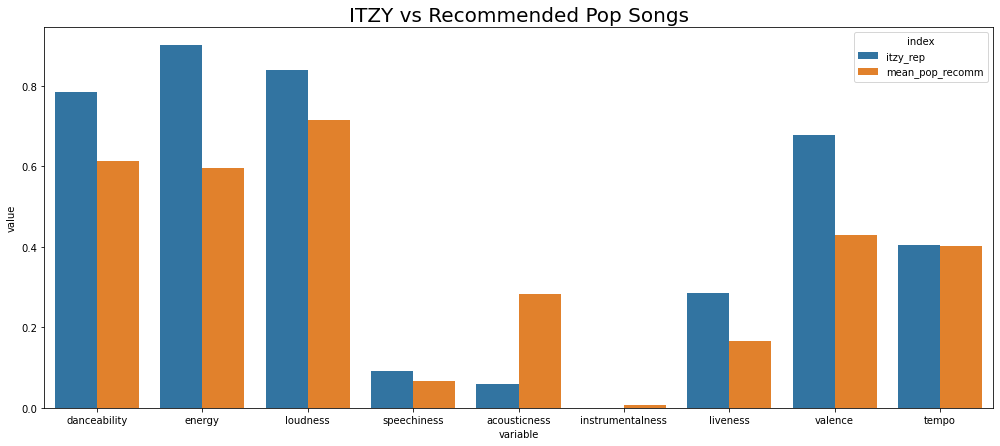

In [456]:
plt.figure(figsize=(17,7))
sns.barplot(data=itzy_v_pop, x='variable', y='value', hue='index')
plt.title('ITZY vs Recommended Pop Songs', fontsize=20)

Text(0.5, 1.0, 'ITZY vs Recommended R&B Songs')

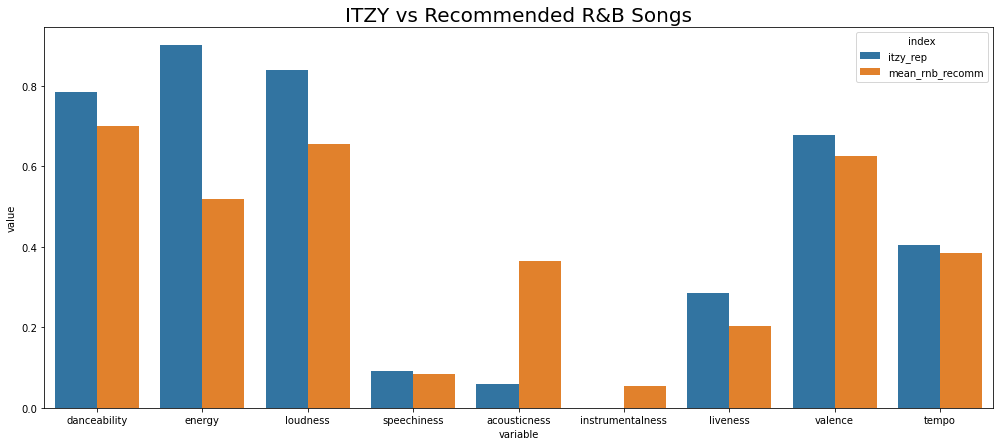

In [457]:
plt.figure(figsize=(17,7))
sns.barplot(data=itzy_v_rnb, x='variable', y='value', hue='index')
plt.title('ITZY vs Recommended R&B Songs', fontsize=20)

Text(0.5, 1.0, 'ITZY vs Recommended Rap Songs')

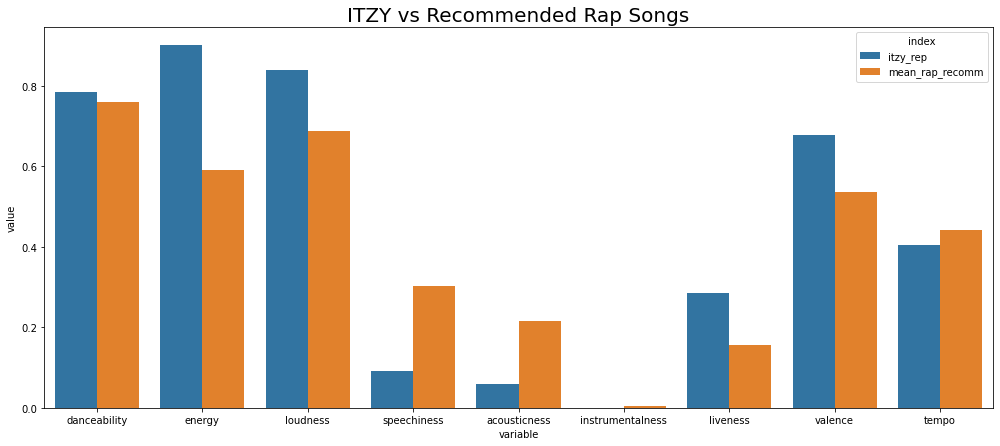

In [458]:
plt.figure(figsize=(17,7))
sns.barplot(data=itzy_v_rap, x='variable', y='value', hue='index')
plt.title('ITZY vs Recommended Rap Songs', fontsize=20)

In [459]:
itzy_v_all = pd.concat( [ itzy_v_pop, itzy_v_rnb, itzy_v_rap ] ).drop_duplicates().sort_values(['variable', 'index'])

itzy_v_all

,index,variable,value
8,itzy_rep,acousticness,0.059077
9,mean_pop_recomm,acousticness,0.283218
9,mean_rap_recomm,acousticness,0.215240
9,mean_rnb_recomm,acousticness,0.364626
0,itzy_rep,danceability,0.785750
1,mean_pop_recomm,danceability,0.614280
1,mean_rap_recomm,danceability,0.759080
1,mean_rnb_recomm,danceability,0.700903
2,itzy_rep,energy,0.900375
3,mean_pop_recomm,energy,0.596614


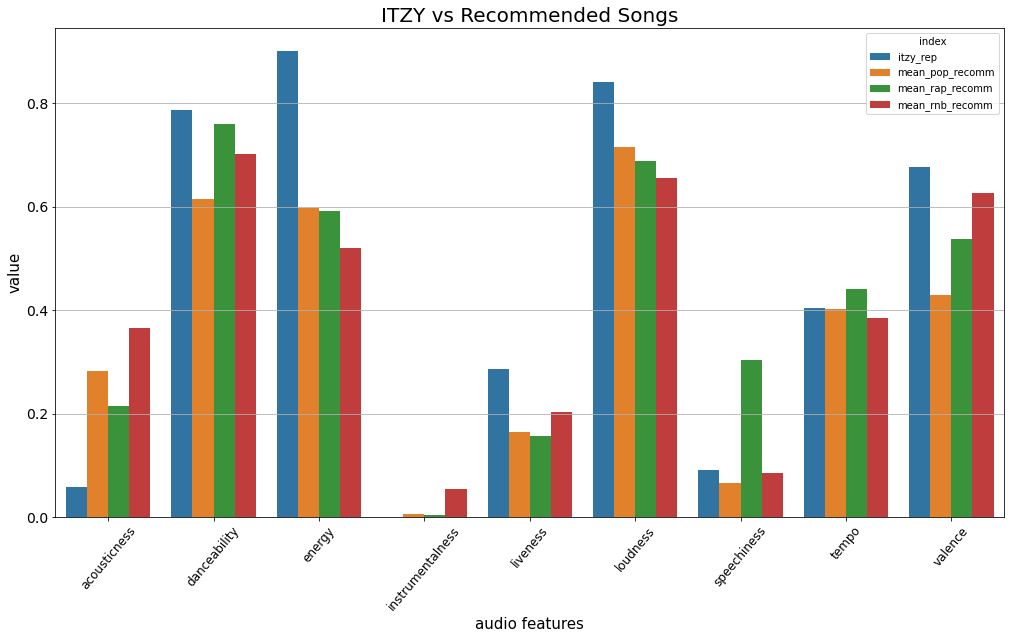

In [460]:
plt.figure(figsize=(17,9))
sns.barplot(data=itzy_v_all, x='variable', y='value', hue='index')

plt.xlabel('audio features', fontsize=15)
plt.ylabel('value', fontsize=15)
plt.xticks(fontsize=12, rotation=50)
plt.yticks(fontsize=14)
plt.title('ITZY vs Recommended Songs', fontsize=20)
plt.grid(True, axis='y')

In [476]:
top_recomms_df_wokpop.columns

Index(['track_id', 'track_name', 'artist_name', 'cosine_dist_mod',
       'predicted_genre', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_pop_prob', 'predicted_rap_prob', 'predicted_rnb_prob'],
      dtype='object')

In [484]:
top_recomms_df_wokpop.head()

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
257,6lD9nDl7jBUSIPDMAMZjuD,Anywhere,Sigma,0.003201,pop,0.717,0.872,0.858588,0.0357,0.0162,0.000002,0.205,0.610,0.415056,0.947368,0.0,0.052632
129,7ju97lgwC2rKQ6wwsf9no9,Rain On Me (with Ariana Grande),Lady Gaga,0.003261,pop,0.672,0.855,0.838731,0.0397,0.0210,0.000000,0.323,0.646,0.433700,0.947368,0.0,0.052632
537,6t2ubAB4iSYOuIpRAOGd4t,Cake - Challenge Version,Flo Rida,0.004508,pop,0.786,0.854,0.818956,0.0523,0.0729,0.000002,0.179,0.687,0.323078,0.894737,0.0,0.105263
572,7aV2mflaASUmGhCErm7kBO,The Mack,Nevada,0.004604,pop,0.707,0.883,0.817564,0.0602,0.0707,0.000000,0.230,0.541,0.328942,0.894737,0.0,0.105263
321,40nPimvmG05WYS7983bawZ,Cry for Me,Camila Cabello,0.004676,pop,0.721,0.805,0.823582,0.0927,0.0500,0.000000,0.153,0.653,0.402946,0.894737,0.0,0.105263


In [486]:
top_recomms_df_wokpop.sort_values('cosine_dist_mod').groupby('predicted_genre').head()\
[['artist_name', 'track_name', 'cosine_dist_mod', 'predicted_genre']]

,artist_name,track_name,cosine_dist_mod,predicted_genre
257,Sigma,Anywhere,0.003201,pop
129,Lady Gaga,Rain On Me (with Ariana Grande),0.003261,pop
537,Flo Rida,Cake - Challenge Version,0.004508,pop
572,Nevada,The Mack,0.004604,pop
321,Camila Cabello,Cry for Me,0.004676,pop
3001,Lost Kings,First Love,0.085184,rap
3017,Drake,Mob Ties,0.086388,rnb
2608,Charlie Puth,Attention,0.089567,rnb
2895,Why Don't We,Big Plans,0.091109,rnb
2907,Kygo,First Time,0.091667,rnb


In [488]:
groups = top_recomms_df_wokpop.sort_values('cosine_dist_mod').groupby('predicted_genre').groups

In [499]:
pop5 = top_recomms_df_wokpop.loc[ groups['pop'] ].head()
pop5

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
257,6lD9nDl7jBUSIPDMAMZjuD,Anywhere,Sigma,0.003201,pop,0.717,0.872,0.858588,0.0357,0.0162,0.000002,0.205,0.610,0.415056,0.947368,0.0,0.052632
129,7ju97lgwC2rKQ6wwsf9no9,Rain On Me (with Ariana Grande),Lady Gaga,0.003261,pop,0.672,0.855,0.838731,0.0397,0.0210,0.000000,0.323,0.646,0.433700,0.947368,0.0,0.052632
537,6t2ubAB4iSYOuIpRAOGd4t,Cake - Challenge Version,Flo Rida,0.004508,pop,0.786,0.854,0.818956,0.0523,0.0729,0.000002,0.179,0.687,0.323078,0.894737,0.0,0.105263
572,7aV2mflaASUmGhCErm7kBO,The Mack,Nevada,0.004604,pop,0.707,0.883,0.817564,0.0602,0.0707,0.000000,0.230,0.541,0.328942,0.894737,0.0,0.105263
321,40nPimvmG05WYS7983bawZ,Cry for Me,Camila Cabello,0.004676,pop,0.721,0.805,0.823582,0.0927,0.0500,0.000000,0.153,0.653,0.402946,0.894737,0.0,0.105263


In [500]:
rnb5 = top_recomms_df_wokpop.loc[ groups['rnb'] ].head()
rnb5

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3017,7txPE73wHbuXYkM1h8zNrG,Mob Ties,Drake,0.086388,rnb,0.755,0.575,0.649253,0.0673,0.0443,0.001270,0.2760,0.493,0.205651,0.421053,0.105263,0.473684
2608,4iLqG9SeJSnt0cSPICSjxv,Attention,Charlie Puth,0.089567,rnb,0.774,0.626,0.811382,0.0432,0.0969,0.000031,0.0848,0.777,0.292085,0.473684,0.000000,0.526316
2895,6Yx181fZzA0YE2EkUsYruq,Big Plans,Why Don't We,0.091109,rnb,0.693,0.604,0.776704,0.0427,0.0668,0.000000,0.1140,0.651,0.138089,0.421053,0.105263,0.473684
2907,2Gl0FzuLxflY6nPifJp5Dr,First Time,Kygo,0.091667,rnb,0.633,0.592,0.696213,0.1120,0.1970,0.000000,0.0990,0.679,0.230707,0.421053,0.105263,0.473684
2881,3A7qX2QjDlPnazUsRk5y0M,2U (feat. Justin Bieber),David Guetta,0.093016,rnb,0.548,0.650,0.754268,0.0591,0.2190,0.000000,0.2250,0.557,0.568337,0.421053,0.105263,0.473684


In [524]:
rap5 = top_recomms_df_wokpop.loc[ groups['rap'] ].head(6)
rap5

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3001,01iyINEYgPQ7ThMZuHUsqS,First Love,Lost Kings,0.085184,rap,0.619,0.938,0.778096,0.350,0.0257,0.000014,0.1280,0.601,0.257252,0.421053,0.473684,0.105263
3158,6qNALlmZa1ESnCxJmXE1K9,The Way I Am,Charlie Puth,0.091890,rap,0.755,0.769,0.761187,0.186,0.3140,0.000002,0.0628,0.642,0.383921,0.368421,0.421053,0.210526
3024,2YpeDb67231RjR0MgVLzsG,Old Town Road - Remix,Lil Nas X,0.093538,rap,0.878,0.619,0.765200,0.102,0.0533,0.000000,0.1130,0.639,0.513598,0.368421,0.473684,0.157895
3049,6u7jPi22kF8CTQ3rb9DHE7,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,0.093538,rap,0.878,0.619,0.765200,0.102,0.0533,0.000000,0.1130,0.639,0.513598,0.368421,0.473684,0.157895
3204,6LcauUZjF1eXQrgqMUecHX,Ayy Macarena,Tyga,0.093649,rap,0.816,0.630,0.764872,0.226,0.1330,0.000000,0.0692,0.715,0.270253,0.368421,0.421053,0.210526
3102,3m660poUr1chesgkkjQM7P,Sorry Not Sorry,Demi Lovato,0.097210,rap,0.704,0.633,0.709396,0.241,0.0214,0.000000,0.2900,0.863,0.562701,0.368421,0.421053,0.210526


In [509]:
pop5[['artist_name', 'cosine_dist_mod']]

,artist_name,cosine_dist_mod
257,Sigma,0.003201
129,Lady Gaga,0.003261
537,Flo Rida,0.004508
572,Nevada,0.004604
321,Camila Cabello,0.004676


In [510]:
rnb5[['artist_name', 'cosine_dist_mod']]

,artist_name,cosine_dist_mod
3017,Drake,0.086388
2608,Charlie Puth,0.089567
2895,Why Don't We,0.091109
2907,Kygo,0.091667
2881,David Guetta,0.093016


In [525]:
rap5[['artist_name', 'cosine_dist_mod']]

,artist_name,cosine_dist_mod
3001,Lost Kings,0.085184
3158,Charlie Puth,0.091890
3024,Lil Nas X,0.093538
3049,Lil Nas X,0.093538
3204,Tyga,0.093649
3102,Demi Lovato,0.097210


In [420]:
top_recomms_df_wokpop[ top_recomms_df_wokpop['track_name'].str.contains('Old Town') ]

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3049,6u7jPi22kF8CTQ3rb9DHE7,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,0.093538,rap,0.878,0.619,0.765200,0.102,0.0533,0.000000,0.1130,0.639,0.513598,0.368421,0.473684,0.157895
3024,2YpeDb67231RjR0MgVLzsG,Old Town Road - Remix,Lil Nas X,0.093538,rap,0.878,0.619,0.765200,0.102,0.0533,0.000000,0.1130,0.639,0.513598,0.368421,0.473684,0.157895
3027,6woeVu3fVMflqen1t4N6pg,Old Town Road (feat. RM of BTS) - Seoul Town R...,Lil Nas X,0.105911,rap,0.890,0.513,0.747349,0.154,0.0706,0.000000,0.1020,0.610,0.513469,0.368421,0.473684,0.157895
3078,53CJANUxooaqGOtdsBTh7O,Old Town Road,Lil Nas X,0.106911,rap,0.908,0.517,0.744606,0.129,0.0361,0.000002,0.0949,0.471,0.513463,0.368421,0.421053,0.210526


In [421]:
top_recomms_df_wokpop[ top_recomms_df_wokpop['track_name'].str.contains('Tour') ]

,track_id,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob
3128,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,0.10101,rap,0.732,0.75,0.732201,0.231,0.00264,0.0,0.109,0.401,0.630847,0.368421,0.421053,0.210526


In [423]:
tracks_to_remove = ['6woeVu3fVMflqen1t4N6pg', '6u7jPi22kF8CTQ3rb9DHE7', '2YpeDb67231RjR0MgVLzsG', '7GX5flRQZVHRAGd6B4TmDO']
tracks_to_remove

['6woeVu3fVMflqen1t4N6pg',
 '6u7jPi22kF8CTQ3rb9DHE7',
 '2YpeDb67231RjR0MgVLzsG',
 '7GX5flRQZVHRAGd6B4TmDO']

In [437]:
final_track_ids = [i for i in top_recomms_df_wokpop.sort_values('track_name')['track_id'].values if i not in tracks_to_remove]

In [440]:
np.array(final_track_ids)

array(['05mAIVLkIWc2d1UBYZBCp8', '3A7qX2QjDlPnazUsRk5y0M',
       '5U0RzSPAVv4jxWkLinGLWF', '0E6PsO3ymCfUh7pJQjBgkj',
       '6lD9nDl7jBUSIPDMAMZjuD', '4iLqG9SeJSnt0cSPICSjxv',
       '6LcauUZjF1eXQrgqMUecHX', '6Yx181fZzA0YE2EkUsYruq',
       '6t2ubAB4iSYOuIpRAOGd4t', '20PUUNHvpjjPh92Q6x0DC4',
       '2gTYVoQCUh0QNUaFix01ld', '40nPimvmG05WYS7983bawZ',
       '48Utf6gNBC9rewCPEvL5ja', '0RTzJVkunbGwuRjXDFHnjf',
       '2LTlO3NuNVN70lp2ZbVswF', '4uqRDeCgXPLQFYqA5uf5Tr',
       '01iyINEYgPQ7ThMZuHUsqS', '2Gl0FzuLxflY6nPifJp5Dr',
       '0PvFJmanyNQMseIFrU708S', '6zGPytJiZmFuyVq7RTNO9G',
       '1IIKrJVP1C9N7iPtG6eOsK', '4ZgZPrrSLi4sIiFkiahuxq',
       '1s7voXUxRTw98pmy1J8urv', '6i0V12jOa3mr6uu4WYhUBr',
       '7qs2GAglLWfxEfmO8u2u0A', '5u1n1kITHCxxp8twBcZxWy',
       '6ju3FaV3aVLzGzwERKZuFK', '5dNfHmqgr128gMY2tc5CeJ',
       '4Q6GncsjUTwWoQO6nsdyA6', '4izP2KMwrhAdZEtIyp8Z8w',
       '073ILU1C3APNRGF66VhtyA', '7eOkHIcaoUhngxxypM5Ajr',
       '7wvYmO5QscgIDDT0eNwbYX', '7oqftogUN82Q7VNy2TmTJW

In [ ]:
# recommendation_df = chart_tracks_df.sort_values('cosine_dist')[:50][['track_id','track_name','artist_name','cosine_dist','predicted_genre']+cols]

In [ ]:
# recommendation_df.head()

In [ ]:
# recommendation_df.describe()

In [ ]:
# recommendation_df['track_id'].values